# Log Analysis and Visulization 2020-02-27

## a) parse log file

In [1]:
# pip install plotly
# conda install -c plotly plotly-orca psutil requests
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 
import os
import shutil
import datetime

In [2]:
# read the log file, save it in a list
def is_json(myjson):
    try:
        json_object = json.loads(myjson)
    except ValueError as e:
        return False
    return True

 
def read_data(files, path):
    data = []
    for file in files:
        with open(path + file, errors='ignore') as f:
            for line in f.readlines():
                try: 
                    if not is_json(line):
                        continue
                    data.append(json.loads(line))
                except:
                    print('bad json: ', line)
    return data

## b) data processing and analysis

In [3]:
# convert the data into pandas dataframe
def data_processing(data):
    df = pd.DataFrame(data) 

    # convert all the keys in the staking into columns, fill nan values
    df = pd.concat([df.drop(['staking'], axis=1), df['staking'].apply(pd.Series)], axis=1)
    df.fillna(0, inplace = True)

    # drop duplicates
    df.drop_duplicates(inplace = True)

    # sort by time 
    df.sort_values(by=['timestamp'], inplace = True)
    df.reset_index(drop = True, inplace = True)
    
    # remove some useless time
    df = df.iloc[1300:]
    df.reset_index(drop = True, inplace = True)
    
    # convert timestamp to datetime64[ns] 
    df["timestamp"] = df["timestamp"].apply(lambda t: t.replace(" +0000 UTC",""))
    df["timestamp"] = pd.to_datetime(df['timestamp'])
       
    # do calculation for each shard
    shard = []
    for name, s in df.groupby("shard"):
        shard.append(s.reset_index(drop = True))
    
    # calculate the average time per block, transaction_per_second
    for s in shard:
        # time per block
        s["time_diff"] = (s['timestamp']-s['timestamp'].shift()).fillna(pd.Timedelta(seconds=0))
        s["block_diff"] = (s['block']-s['block'].shift()).fillna(0).astype(int)
        s["epoch_diff"] = (s['epoch']-s['epoch'].shift()).fillna(0).astype(int)
        s["time_per_block"] = s.apply(lambda c: c["time_diff"].seconds /c["block_diff"] \
                                      if c["block_diff"] != 0 else np.nan, axis = 1)

        # plain transaction_per_second
        s["transaction_per_second"] = s.apply(lambda c: c["transactions"]/c["time_diff"].seconds \
                                              if c["time_diff"].seconds != 0 else np.nan, axis = 1)
        # staking transaction_per_second
        s["staking_transaction_per_second"] = s.apply(lambda c: c["total"]/c["time_diff"].seconds \
                                              if c["time_diff"].seconds != 0 else np.nan, axis = 1)
        # total transacton per second
        s["total_transaction_per_second"] = s["transaction_per_second"] + s["staking_transaction_per_second"]
        
        s.rename(columns={"total": "total_staking"}, inplace = True)
        s.drop(['time_diff', 'block_diff'], axis=1, inplace = True)
    return shard

## c) draw the graph 

In [4]:
# draw the graphs with x-axis time
def draw_graph_time(df, fig_path, state):
    
    html_path = fig_path + "html/"
    png_path = fig_path + "png/"

    print("Features vs Time")
    print("PNG saved in " + png_path)
    print("==================================")
    if not os.path.exists(html_path):
        os.makedirs(html_path)
        
    if not os.path.exists(png_path):
        os.makedirs(png_path)

    colors = ["#00AEE9","#FFA07A","#758796"]
    hover = df.columns.tolist()
    
    fig = px.line(df, x="timestamp", y="staking_transaction_per_second", color='shard', color_discrete_sequence=colors, \
                  title = 'Staking Transaction Per Second vs Time '+ state, hover_data=hover)
    fig.update_layout(xaxis_title="utc_time")
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "staking_transaction_per_second_vs_time.html")
    fig.write_image(png_path + "staking_transaction_per_second_vs_time.png",width=900, height=500)
    
    
    fig = px.line(df, x="timestamp", y="total_transaction_per_second", color='shard', color_discrete_sequence=colors, \
                  title = 'Total Transaction Per Second vs Time '+ state, hover_data=hover)
    fig.update_layout(xaxis_title="utc_time")
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "total_transaction_per_second_vs_time.html")
    fig.write_image(png_path + "total_transaction_per_second_vs_time.png",width=900, height=500)
    
    fig = px.line(df, x='timestamp', y='transaction_per_second', color='shard', color_discrete_sequence=colors, \
                  title = 'Transaction Per Second vs Time '+ state, hover_data=hover)
    fig.update_layout(xaxis_title="utc_time")
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "transaction_per_second_vs_time.html")
    fig.write_image(png_path + "transaction_per_second_vs_time.png",width=900, height=500)
    
    fig = px.line(df, x="timestamp", y="time_per_block", color='shard', color_discrete_sequence=colors, \
                  title = 'Time Per Block vs Time '+ state, hover_data=hover)
    fig.update_layout(xaxis_title="utc_time")
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "time_per_block_vs_time.html")
    fig.write_image(png_path + "time_per_block_vs_time.png",width=900, height=500)
    
    
    fig = px.line(df, x="timestamp", y="size", color='shard', color_discrete_sequence=colors, \
                  title = 'Size vs Time '+ state, hover_data=hover)
    fig.update_layout(xaxis_title="utc_time")
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "size_vs_time.html")
    fig.write_image(png_path + "size_vs_time.png",width=900, height=500)
    
    fig = px.line(df, x="timestamp", y="gas", color='shard', color_discrete_sequence=colors, \
                  title = 'Gas vs Time '+ state, hover_data=hover)
    fig.update_layout(xaxis_title="utc_time")
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "gas_vs_time.html")
    fig.write_image(png_path + "gas_vs_time.png",width=900, height=500)
    

In [5]:
# draw the graphs with x-axis utc time for each shard
def draw_graph_time_per_shard(df, fig_path, idx, state, epo_idx):
    
    html_path = fig_path + "html/"
    png_path = fig_path + "png/"

    print("Features vs UTC Time Graphs for shard " + str(idx))
    print("PNG saved in " + png_path)
    print("==================================")
    if not os.path.exists(html_path):
        os.makedirs(html_path)
        
    if not os.path.exists(png_path):
        os.makedirs(png_path)
    
    shard_idx = "shard "+str(idx)
    colors = ["#00AEE9"]
    hover = df.columns.tolist()
    
    if idx == 0:
        fig = px.line(df, x="timestamp", y="staking_transaction_per_second", color='shard', color_discrete_sequence=colors,\
                  title = shard_idx + ' Staking Transaction Per Second vs UTC Time '+ state, hover_data=hover)
        fig.update_layout(xaxis_title="utc_time")
        for i in epo_idx:
            fig.add_shape(type="line", x0=df.iloc[i]["timestamp"], y0=0,x1=df.iloc[i]["timestamp"],y1=1,
                    line=dict(
                    width=1,
                    dash="dot",
                ))
        fig.update_shapes(dict(xref='x', yref='paper'))
        fig.show(renderer="svg",width=900, height=500)
        fig.write_html(html_path + shard_idx + "_staking_transaction_per_second_vs_utc_time.html")
        fig.write_image(png_path + shard_idx + "_staking_transaction_per_second_vs_utc_time.png")


        fig = px.line(df, x="timestamp", y="total_transaction_per_second", color='shard', color_discrete_sequence=colors,\
                      title = shard_idx + ' Total Transaction Per Second vs UTC Time '+ state, hover_data=hover)
        fig.update_layout(xaxis_title="utc_time")
        fig.show(renderer="svg",width=900, height=500)
        fig.write_html(html_path + shard_idx + "_total_transaction_per_second_vs_utc_time.html")
        fig.write_image(png_path + shard_idx + "_total_transaction_per_second_vs_utc_time.png")

    fig = px.line(df, x='timestamp', y='transaction_per_second', color='shard', color_discrete_sequence=colors, \
              title = shard_idx + ' Transaction Per Second vs UTC Time '+state, hover_data=hover)
    fig.update_layout(xaxis_title="utc_time")
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + shard_idx + "_transaction_per_second_vs_utc_time.html")
    fig.write_image(png_path + shard_idx + "_transaction_per_second_vs_utc_time.png")

    fig = px.line(df, x="timestamp", y="time_per_block", color='shard', color_discrete_sequence=colors,\
                  title = shard_idx + ' Time Per Block vs UTC Time '+ state, hover_data=hover)
    fig.update_layout(xaxis_title="utc_time")
    fig.write_html(html_path + shard_idx + "_time_per_block_vs_utc_time.html")
    fig.write_image(png_path + shard_idx + "_time_per_block_vs_utc_time.png")
    fig.show(renderer="svg",width=900, height=500)
    
    fig = px.line(df, x="timestamp", y="size", color='shard', color_discrete_sequence=colors, \
                  title = shard_idx + ' Size vs UTC Time '+ state, hover_data=hover)
    fig.update_layout(xaxis_title="utc_time")
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + shard_idx + "_size_vs_utc_time.html")
    fig.write_image(png_path + shard_idx + "_size_vs_utc_time.png")


    fig = px.line(df, x="timestamp", y="gas", color='shard', color_discrete_sequence=colors,\
                  title = shard_idx + ' Gas vs UTC Time '+ state, hover_data=hover)
    fig.update_layout(xaxis_title="utc_time")
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + shard_idx + "_gas_vs_utc_time.html")
    fig.write_image(png_path + shard_idx + "_gas_vs_utc_time.png")

In [6]:
# draw the graphs with x-axis block height
def draw_graph_block(df, fig_path, state):
    
    html_path = fig_path + "html/"
    png_path = fig_path + "png/"

    print("Features vs Block Height")
    print("PNG saved in " + png_path)
    print("==================================")
    if not os.path.exists(html_path):
        os.makedirs(html_path)
        
    if not os.path.exists(png_path):
        os.makedirs(png_path)
    
    colors = ["#00AEE9","#FFA07A","#758796"]
    hover = df.columns.tolist()
    
    fig = px.line(df, x="block", y="staking_transaction_per_second", color='shard', color_discrete_sequence=colors, \
                  title = 'Staking Transaction Per Second vs Block Height '+ state, hover_data=hover)
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "staking_transaction_per_second_vs_block_height.html")
    fig.write_image(png_path + "staking_transaction_per_second_vs_block_height.png",width=900, height=500)

    fig = px.line(df, x="block", y="total_transaction_per_second", color='shard', color_discrete_sequence=colors, \
                  title = 'Total Transaction Per Second vs Block Height '+ state, hover_data=hover)
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "total_transaction_per_second_vs_block_height.html")
    fig.write_image(png_path + "total_transaction_per_second_vs_block_height.png",width=900, height=500)

    fig = px.line(df, x='block', y='transaction_per_second', color='shard', color_discrete_sequence=colors, \
                  title = 'Transaction Per Second vs Block Height '+ state, hover_data=hover)
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "transaction_per_second_vs_block_height.html")
    fig.write_image(png_path + "transaction_per_second_vs_block_height.png",width=900, height=500)
    
    fig = px.line(df, x="block", y="time_per_block", color='shard', color_discrete_sequence=colors, \
                  title = 'Time Per Block vs Block Height '+ state, hover_data=hover)
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "time_per_block_vs_block_height.html")
    fig.write_image(png_path + "time_per_block_vs_block_height.png",width=900, height=500)
    
    
    fig = px.line(df, x="block", y="size", color='shard', color_discrete_sequence=colors, \
                  title = 'Size vs Block Height '+ state, hover_data=hover)
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "size_vs_block_height.html")
    fig.write_image(png_path + "size_vs_block_height.png",width=900, height=500)
    
    
    fig = px.line(df, x="block", y="gas", color='shard', color_discrete_sequence=colors, \
                  title = 'Gas vs Block '+ state, hover_data=hover)
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "gas_vs_block_height.html")
    fig.write_image(png_path + "gas_vs_block_height.png",width=900, height=500)
    
    

In [7]:
# draw the graphs with x-axis block height for each shard
def draw_graph_block_per_shard(df, fig_path, idx, state):
    
    html_path = fig_path + "html/"
    png_path = fig_path + "png/"

    print("Features vs Block Height Graphs for shard " + str(idx))
    print("PNG saved in " + png_path)
    print("==================================")
    if not os.path.exists(html_path):
        os.makedirs(html_path)
        
    if not os.path.exists(png_path):
        os.makedirs(png_path)
    
    shard_idx = "shard "+str(idx)
    colors = ["#00AEE9"]
    hover = df.columns.tolist()
    
    if idx == 0:
        fig = px.line(df, x="block", y="staking_transaction_per_second", color='shard', color_discrete_sequence=colors,\
                  title = shard_idx + ' Staking Transaction Per Second vs Time '+ state, hover_data=hover)
        fig.show(renderer="svg",width=900, height=500)
        fig.write_html(html_path + shard_idx + "_staking_transaction_per_second_vs_block_height.html")
        fig.write_image(png_path + shard_idx + "_staking_transaction_per_second_vs_block_height.png")

        fig = px.line(df, x="block", y="total_transaction_per_second", color='shard', color_discrete_sequence=colors,\
                      title = shard_idx + ' Total Transaction Per Second vs Time '+ state, hover_data=hover)
        fig.show(renderer="svg",width=900, height=500)
        fig.write_html(html_path + shard_idx + "_total_transaction_per_second_vs_block_height.html")
        fig.write_image(png_path + shard_idx + "_total_transaction_per_second_vs_block_height.png")
    
    fig = px.line(df, x='block', y='transaction_per_second', color='shard', color_discrete_sequence=colors,\
                  title = shard_idx + ' Transaction Per Second vs Block Height '+state, hover_data=hover)
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + shard_idx + "_transaction_per_second_vs_block_height.html")
    fig.write_image(png_path + shard_idx + "_transaction_per_second_vs_block_height.png")

    fig = px.line(df, x="block", y="time_per_block", color='shard', color_discrete_sequence=colors,\
                  title = shard_idx + ' Time Per Block vs Time '+ state, hover_data=hover)
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + shard_idx + "_time_per_block_vs_block_height.html")
    fig.write_image(png_path + shard_idx + "_time_per_block_vs_block_height.png")


    fig = px.line(df, x="block", y="size", color='shard', color_discrete_sequence=colors,\
                  title = shard_idx + ' Size vs Time '+ state, hover_data=hover)
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + shard_idx + "_size_vs_block_height.html")
    fig.write_image(png_path + shard_idx + "_size_vs_block_height.png")


    fig = px.line(df, x="block", y="gas", color='shard', color_discrete_sequence=colors,\
                  title = shard_idx + ' Gas vs Time '+ state, hover_data=hover)
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + shard_idx + "_gas_vs_block_height.html")
    fig.write_image(png_path + shard_idx + "_gas_vs_block_height.png")
    

# Result
- transaction per second vs time 
- staking transaction per second vs time
- total transaction per second vs time
- time per block vs time
- size vs time
- gas vs time
- transaction per second vs block height
- staking transaction per second vs block height
- total transaction per second vs block height
- time per block vs block height
- size vs block height
- gas vs block height

In [8]:
log_path = "../../logs/test_logs/stress_test_02_27/"
fig_folder = "../../graphs/test_logs/stress_test_02_27/"
if os.path.exists(fig_folder):
    shutil.rmtree(fig_folder)
    os.mkdir(fig_folder)

files = os.listdir(log_path)    
data = read_data(files, log_path)
shard = data_processing(data)

# get the index of blockchain changes 
state = ["When DOS Disabled in Tx Pool", "When DOS Enabled in Tx Pool"]
index = []
for s in shard:
    i = s[s['time_per_block'] < 0].index.tolist()      
    i.insert(0,0)
    i.append(len(s))
    index.append(i)

## Graphs when POS Disabled in Tx Pool

### Graphs for each shard

Statistics summary for shard 0
Total data points: 463
               size           gas  transaction_per_second  time_per_block
mean   30395.211663  5.080126e+06               21.026247        9.716703
std    23746.680815  4.228056e+06               15.353972        3.218712
min      695.000000  0.000000e+00                0.000000        8.000000
25%    18254.500000  3.192000e+06               11.250000        8.000000
50%    25460.000000  4.305000e+06               21.882353        8.000000
75%    39020.000000  5.586000e+06               25.500000        9.000000
max   224565.000000  4.317600e+07              170.500000       27.000000

Features vs UTC Time Graphs for shard 0
Features vs UTC Time Graphs for shard 0
PNG saved in ../../graphs/test_logs/stress_test_02_27/POS_disabled/png/


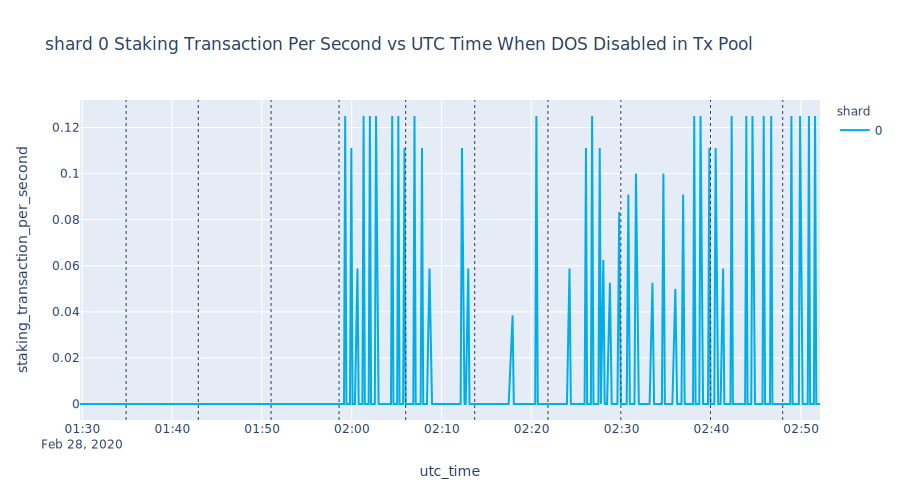

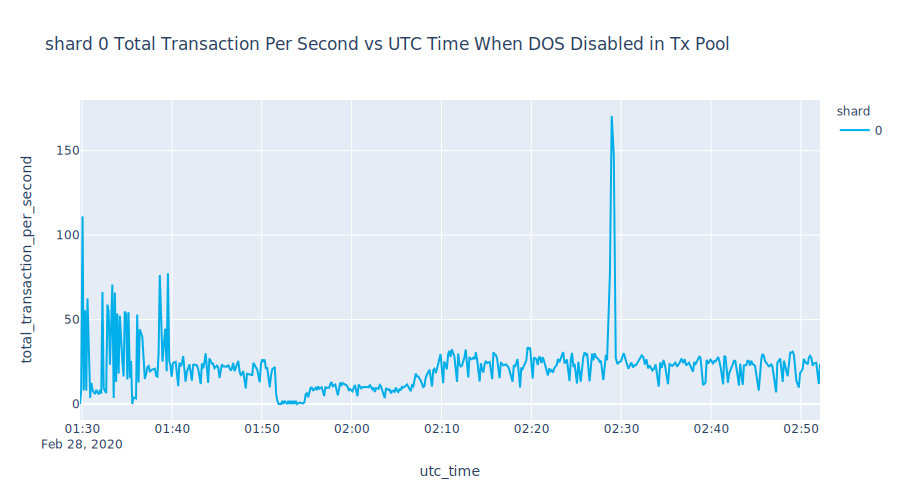

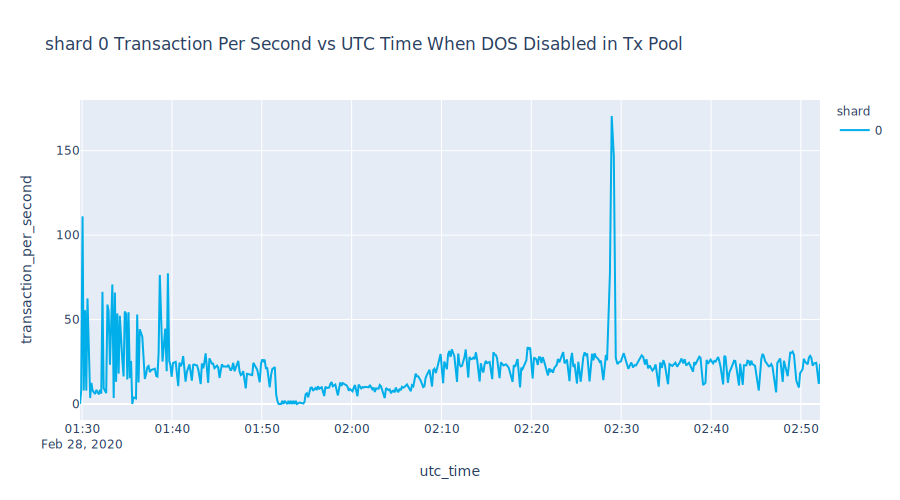

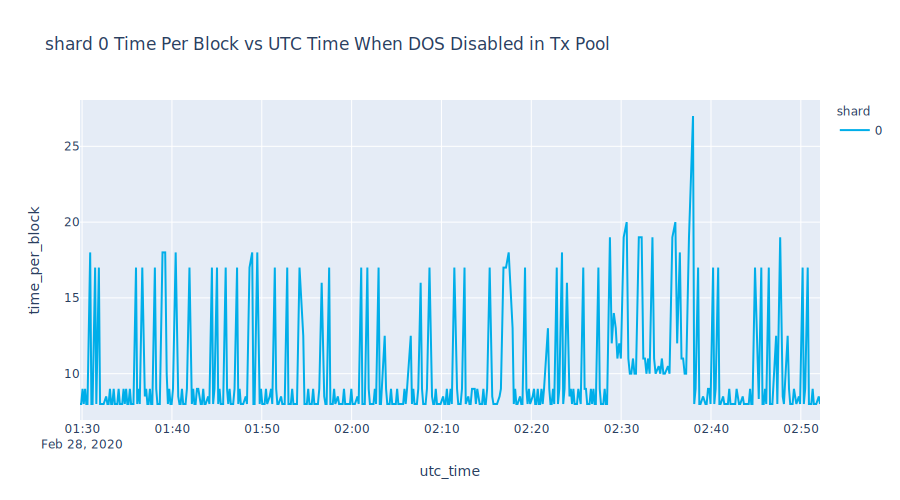

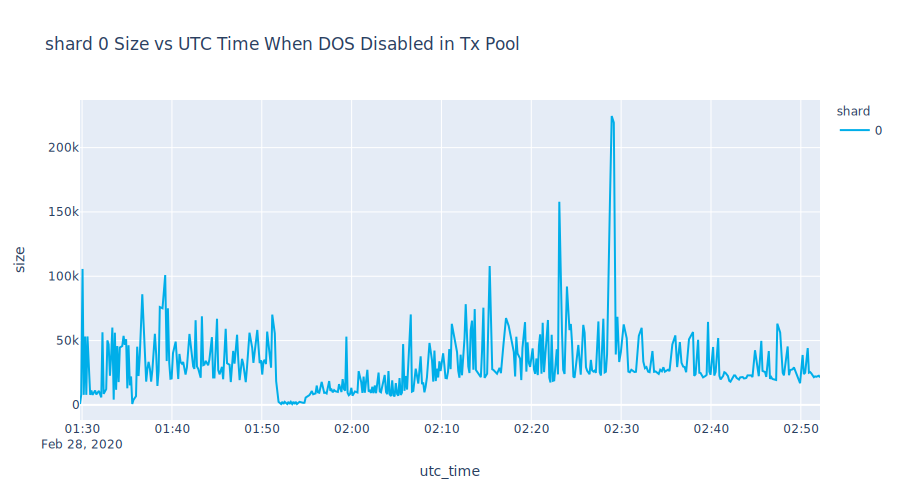

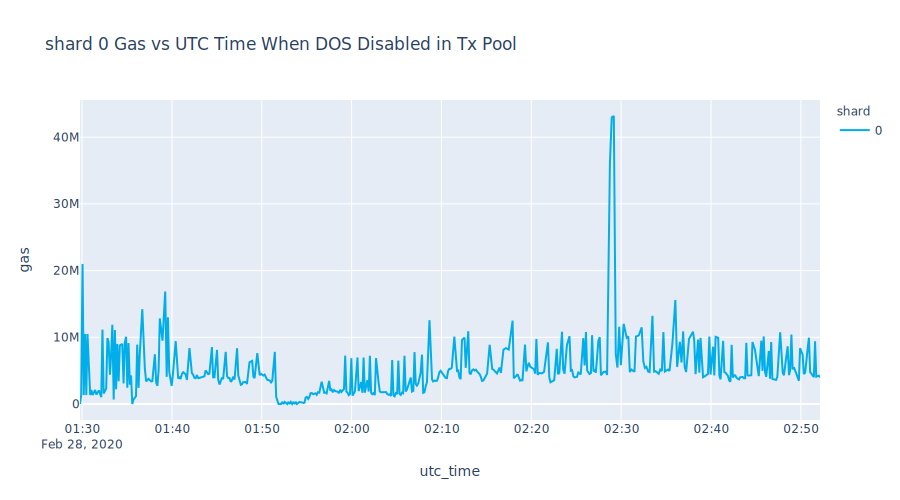

Statistics summary for shard 1
Total data points: 198
               size           gas  transaction_per_second  time_per_block
mean   61560.722222  8.664409e+06               28.694424       16.628788
std    57966.894238  8.093147e+06               24.417424       12.597330
min      695.000000  0.000000e+00                0.000000        8.000000
25%    29587.250000  3.549000e+06                8.558621        9.000000
50%    54397.000000  7.822500e+06               22.003268       10.000000
75%    83892.750000  1.185975e+07               42.650000       21.000000
max   471823.000000  7.400400e+07              130.518519      105.000000

Features vs UTC Time Graphs for shard 1
Features vs UTC Time Graphs for shard 1
PNG saved in ../../graphs/test_logs/stress_test_02_27/POS_disabled/png/


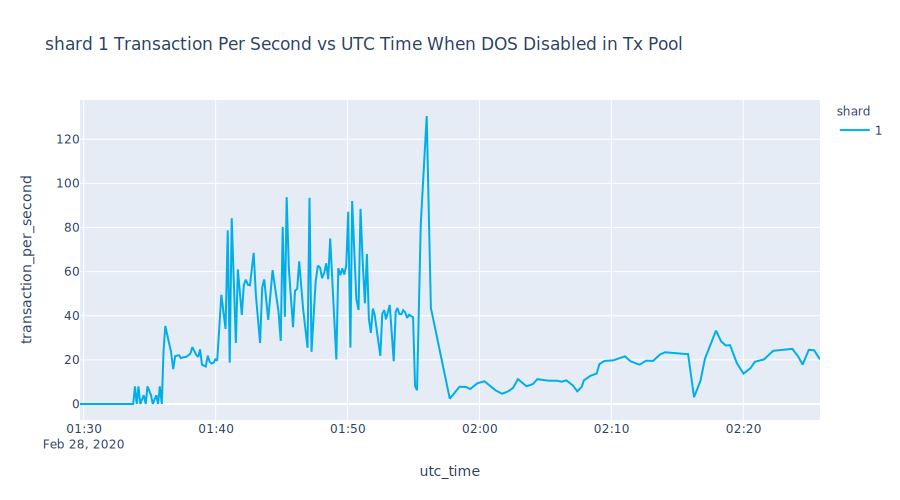

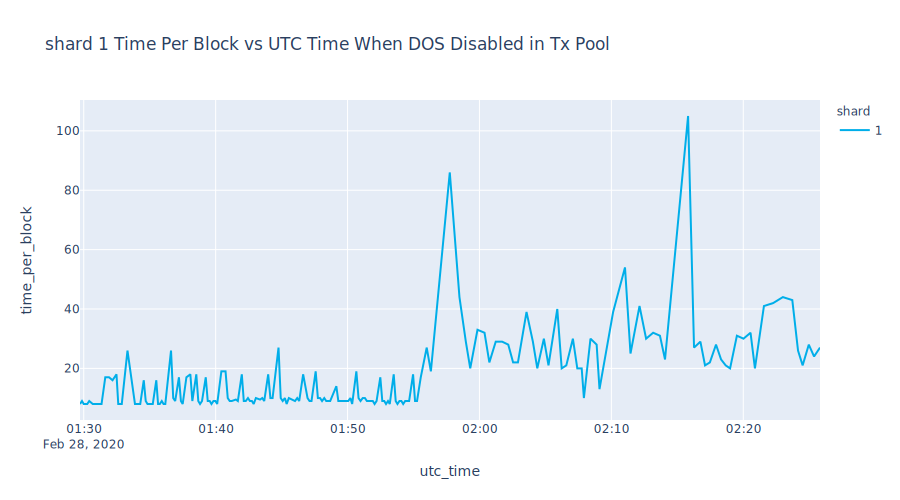

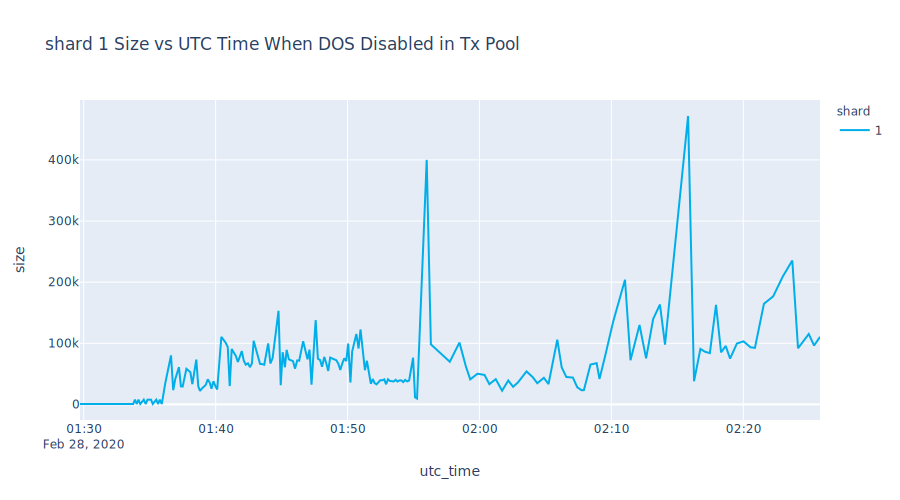

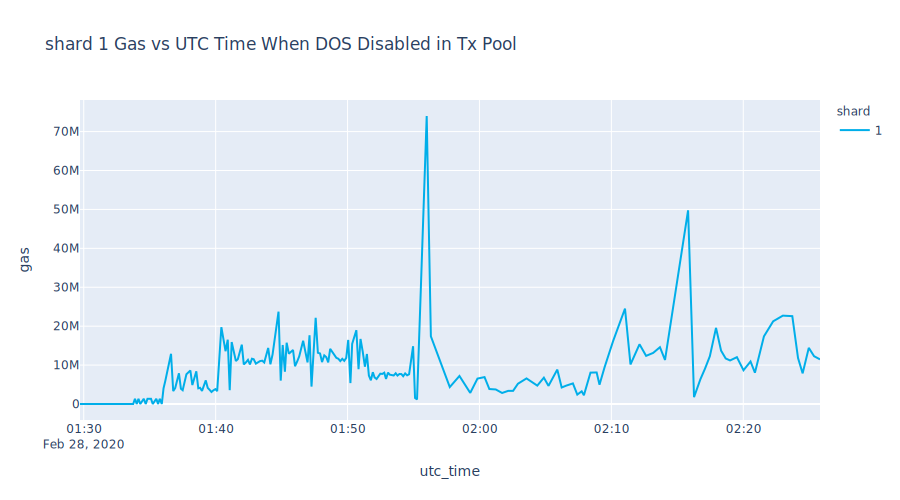

Statistics summary for shard 2
Total data points: 244
               size           gas  transaction_per_second  time_per_block
mean   21863.094262  3.032779e+06                9.484372       13.813525
std    44878.673399  6.864147e+06               25.680807       12.762352
min      695.000000  0.000000e+00                0.000000        8.000000
25%      695.000000  0.000000e+00                0.000000        8.000000
50%      695.000000  0.000000e+00                0.000000        8.000000
75%    19790.250000  2.446500e+06                6.890909       13.000000
max   347435.000000  6.820800e+07              216.533333       94.000000

Features vs UTC Time Graphs for shard 2
Features vs UTC Time Graphs for shard 2
PNG saved in ../../graphs/test_logs/stress_test_02_27/POS_disabled/png/


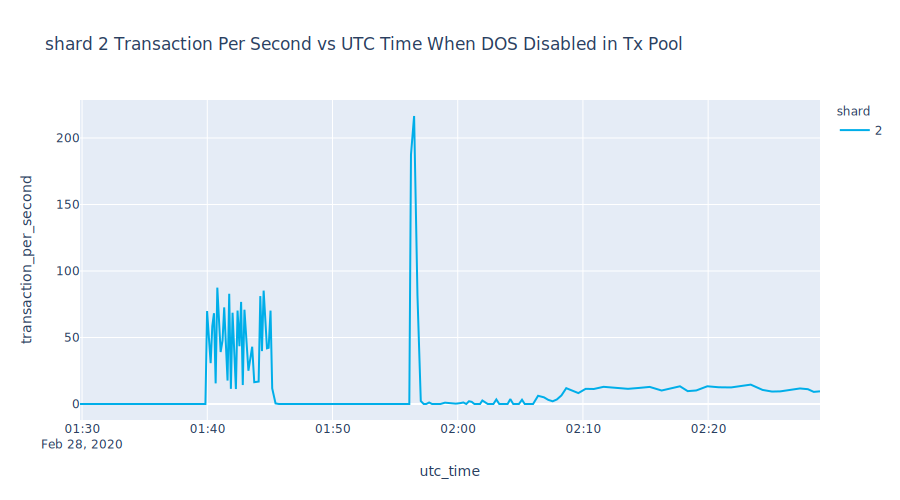

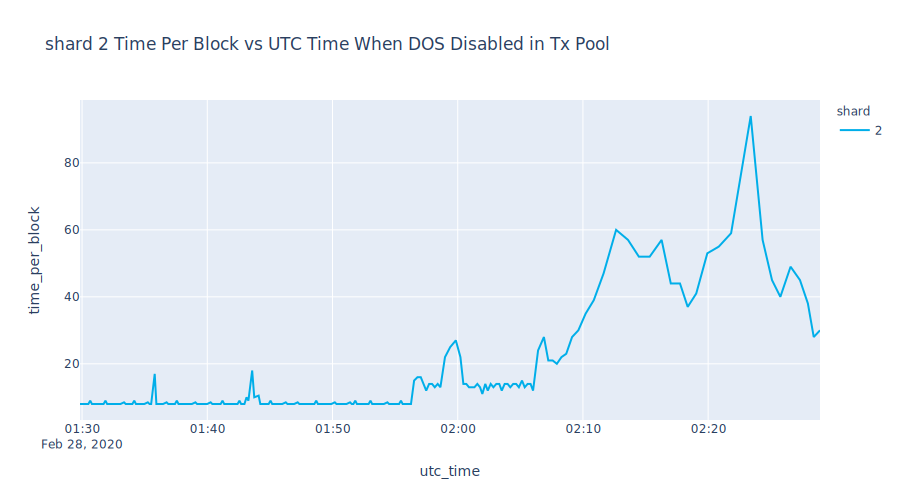

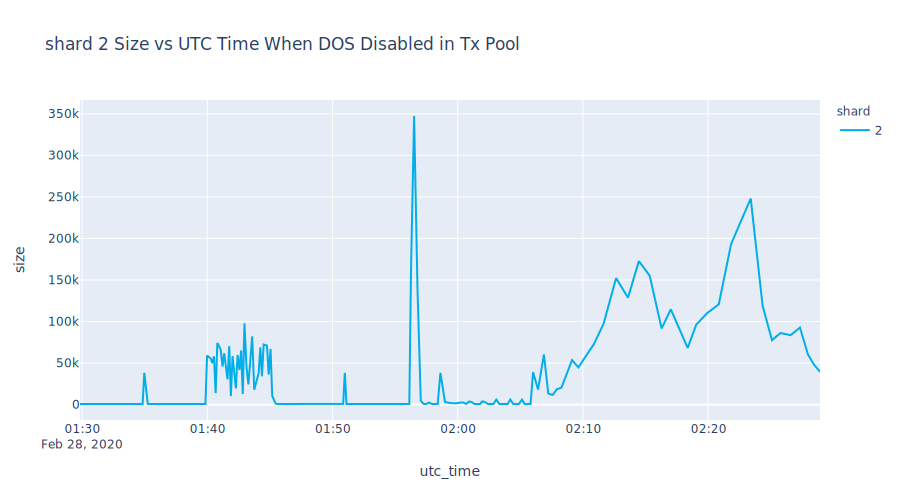

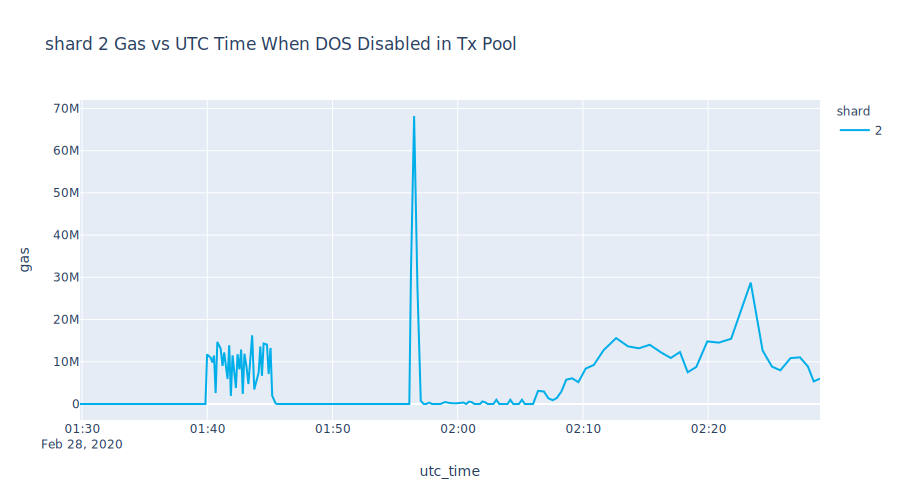

In [9]:
# get figures and statistics summary for each blockchain
# for i in range(len(index[0])-1):
df = []
for s in range(len(shard)):
    df.append(shard[s].iloc[index[s][0]+1:index[s][1]])
new = pd.concat(df)

fig_path = fig_folder + "POS_disabled/"
if os.path.exists(fig_path):
    shutil.rmtree(fig_path)
os.mkdir(fig_path)

# statistics summary for each shard
for name, group in new.dropna().groupby("shard"):

    print("Statistics summary for shard " + str(name))
    print("==================================")
    summary = group[["size","gas","transaction_per_second","time_per_block"]].describe()
    print("Total data points: " + str(summary.iloc[0][0].astype(int)))
    print(summary.iloc[1:])
    print("")
    
    epo_idx = group[group['epoch_diff'] > 0].index.tolist()
    print("Features vs UTC Time Graphs for shard " + str(name))
    print("==================================")
    draw_graph_time_per_shard(group, fig_path, name, state[0], epo_idx)
#     print("")
#     print("Features vs Block Height Graphs for shard " + str(name))
#     print("==================================")
#     draw_graph_block_per_shard(group, fig_path, name, state[0])
#     print("")



### Graphs for all shards together 

Features vs Time
Features vs Time
PNG saved in ../../graphs/test_logs/stress_test_02_27/POS_disabled/png/


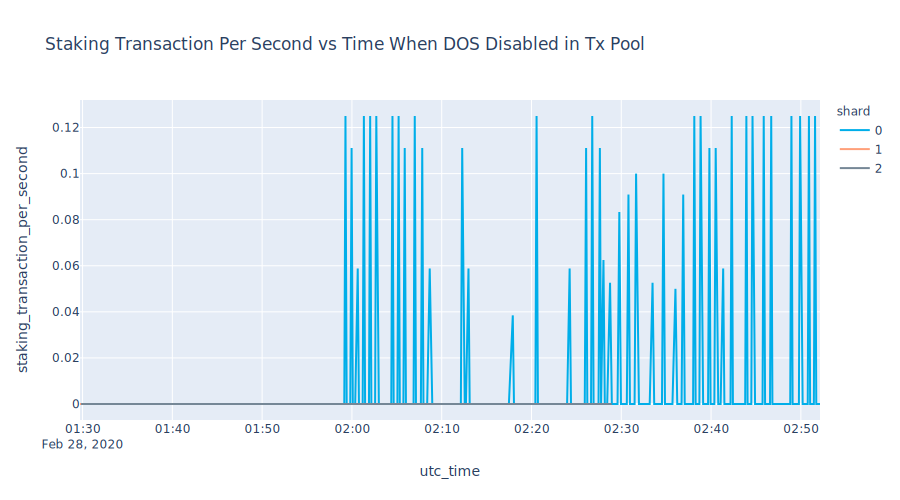

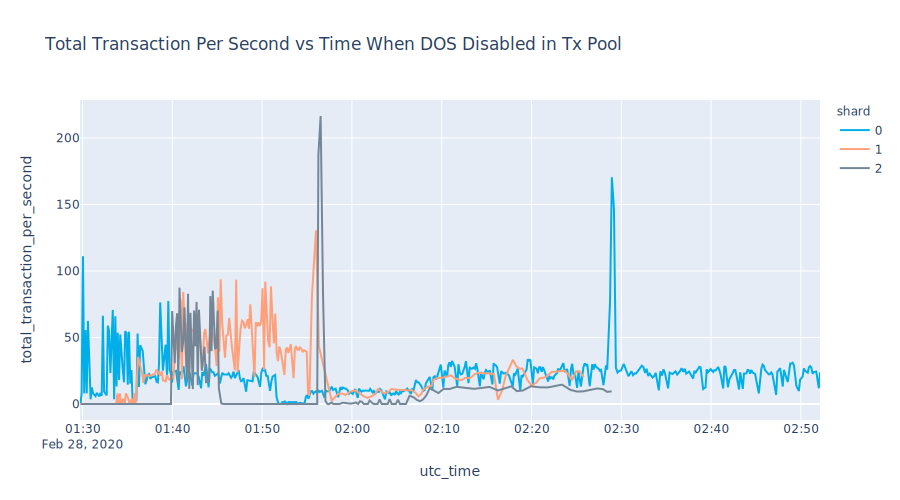

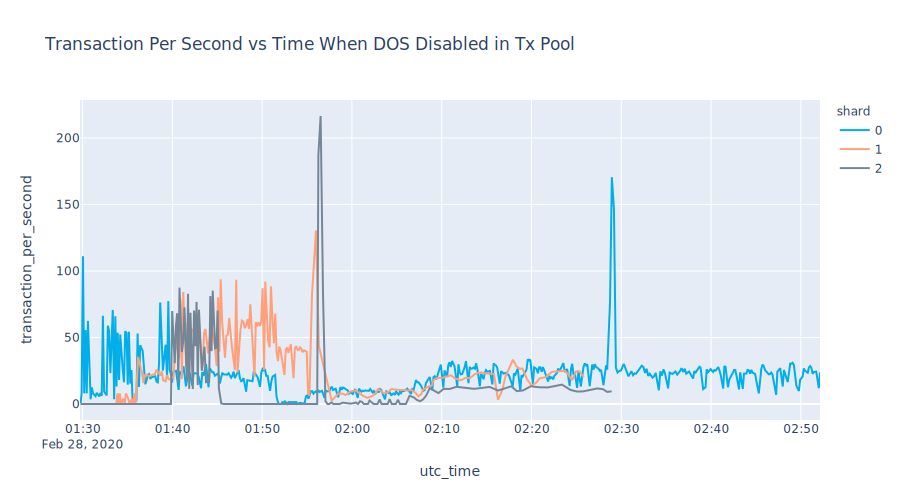

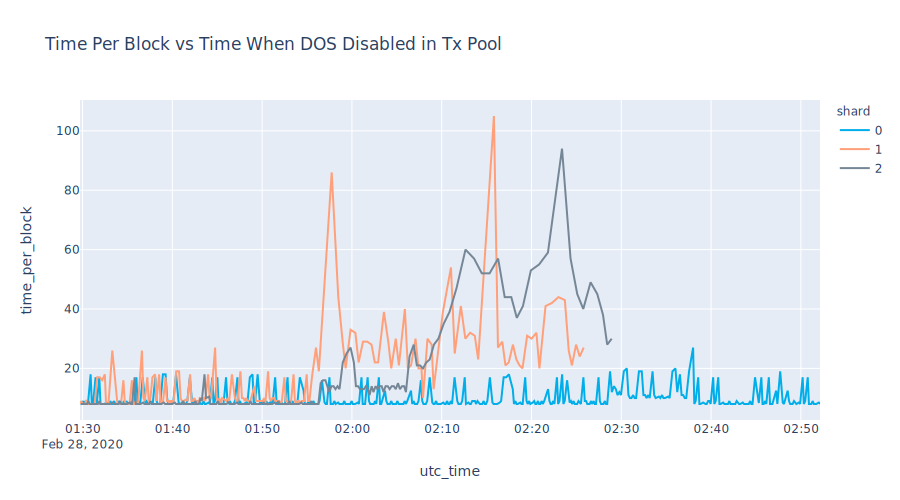

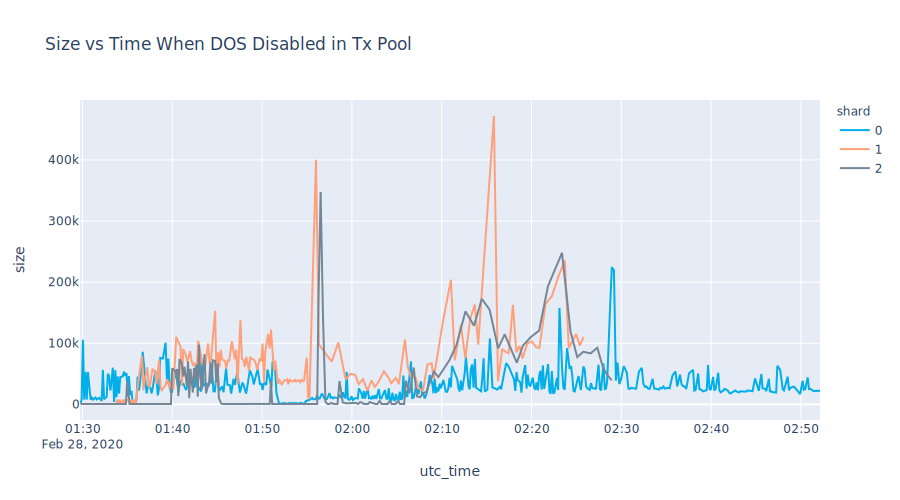

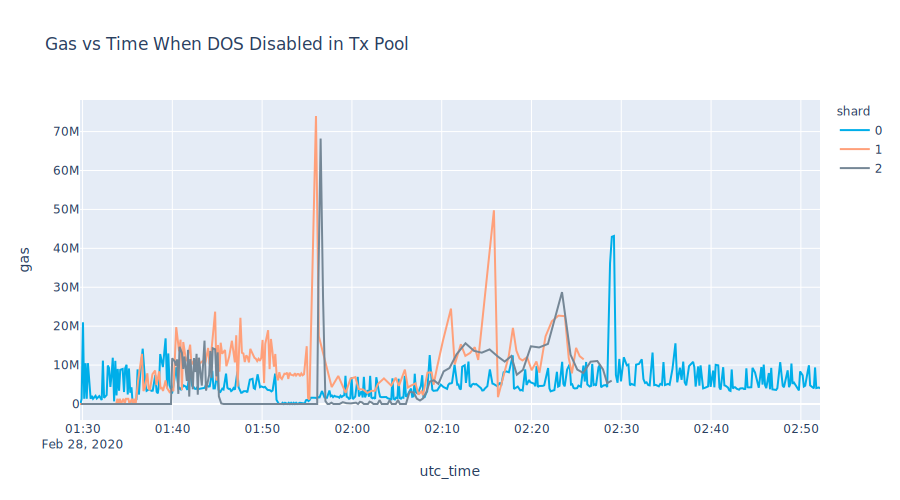

In [10]:
# draw the figure 
print("Features vs Time")
print("==================================")
draw_graph_time(new, fig_path, state[0])
# print("Features vs Block Height")
# print("==================================")
# draw_graph_block(new, fig_path, state[0])

## Graphs when POS Enabled in Tx Pool

### Graphs for each shard

In [ ]:
df = []
for s in range(len(shard)):
    df.append(shard[s].iloc[index[s][1]+1:index[s][2]])
new = pd.concat(df)

new.reset_index(drop = True, inplace = True)
fig_path = fig_folder + "POS_enabled/"
if os.path.exists(fig_path):
    shutil.rmtree(fig_path)
os.mkdir(fig_path)

In [ ]:
for name, group in new.dropna().groupby("shard"):
    
    print("Statistics summary for shard " + str(name))
    print("==================================")
    summary = group[["size","gas","transaction_per_second","time_per_block"]].describe()
    print("Total data points: " + str(summary.iloc[0][0].astype(int)))
    print(summary.iloc[1:])
    print("")

    epo_idx = group[group['epoch_diff'] > 0].index.tolist()
    print("Features vs UTC Time Graphs for shard " + str(name))
    print("==================================")
    draw_graph_time_per_shard(group, fig_path, name, state[1], epo_idx)
    print("")

#     print("Features vs Block Height Graphs for shard " + str(i))
#     print("==================================")
#     draw_graph_block_per_shard(shard[i], fig_path, i, state[1])
#     print("")

### Graphs for all shards together 

In [ ]:
# draw the figure 
print("Features vs Time")
print("==================================")
draw_graph_time(new, fig_path, state[1])
print("Features vs Block Height")
print("==================================")
draw_graph_block(new, fig_path, state[1])